In [9]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from sklearn.datasets import load_diabetes
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn.model_selection import train_test_split
plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 3
#input csv files of all data
total_nut_day_1_df = pd.read_csv("Input_data/DR1TOT.csv") #, dtype = np.float64) #convert_float = True)
total_nut_day_1_df = total_nut_day_1_df.replace(" ", "-1000")
total_nut_day_2_df = pd.read_csv("Input_data/DR2TOT.csv")
total_nut_day_2_df = total_nut_day_2_df.replace(" ", "-1000")
ind_food_1_df = pd.read_csv("Input_data/DR1IFF_I.csv")
ind_food_2_df = pd.read_csv("Input_data/DR2IFF.csv")
demo_df = pd.read_csv("Input_data/Demographics.csv")
A_Data= pd.read_csv ("Input_data/A_based_on_data.csv")
b_Data= pd.read_csv ("Input_data/b_MLIO.csv")
#A_general_reduced = pd.read_csv ("A-matrix-General.csv")
#A_general = pd.read_csv ("A-matrix-General - All foods.csv")
#nitrient_bounds_df = pd.read_csv ("Nutrient_bounds.csv")
total_nut_day_1_df = total_nut_day_1_df.astype(float)
total_nut_day_2_df = total_nut_day_2_df.astype(float)
total_nut_day_1_df_mod = total_nut_day_1_df[(total_nut_day_1_df.DR1TSODI <= 3000)]
total_nut_day_2_df_mod = total_nut_day_2_df[(total_nut_day_2_df.DR2TSODI <= 3000)  ]
df_temp = total_nut_day_2_df_mod[total_nut_day_2_df_mod.SEQN.isin(total_nut_day_1_df_mod.SEQN)]
ind_food_1_df_mod = ind_food_1_df#[ind_food_1_df.SEQN.isin(df_temp.SEQN)]
ind_food_1_df_mod.DR1IFDCD = np.floor(ind_food_1_df_mod.DR1IFDCD/1000000).astype(int)
ind_food_2_df_mod = ind_food_2_df#[ind_food_2_df.SEQN.isin(df_temp.SEQN)]
ind_food_2_df_mod.DR2IFDCD = np.floor(ind_food_2_df_mod.DR2IFDCD/1000000).astype(int)
#ind_food_1_df_mod.DR1IFDCD
#ind_food_2_df_mod.DR2IFDCD
demo_df_mod = demo_df[demo_df.SEQN.isin(df_temp.SEQN)]
demo_df_mod_male = demo_df_mod[demo_df_mod.RIAGENDR == 1]
demo_df_mod_female = demo_df_mod[demo_df_mod.RIAGENDR == 2]
#Age divide
demo_all = demo_df_mod [(demo_df_mod.RIDAGEYR >= 18) & (demo_df_mod.RIDAGEYR <= 75)]


In [13]:
def plot_coloured_clusters(X,centroids,count):
    h = .01    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = 1, 10
    y_min, y_max = 1, 10
#    x_min, x_max = X.T[:, 0].min() -.5, X.T[:, 0].max() +.5
#    y_min, y_max = X.T[:, 1].min() -.5, X.T[:, 1].max() +.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    xx1 = xx.reshape((xx.shape[0]*xx.shape[0],1))
    yy1 = yy.reshape((yy.shape[0]*yy.shape[0],1))
    xxyy1 = np.concatenate((xx1, yy1), axis=1)
    #xxyy_centroid = find_cluster(xxyy1.T, data)
    xxyy_centroid = find_cluster_from_centroid(xxyy1.T, centroids)
    P = xxyy_centroid[2].reshape(xx.shape)
    plt.figure(figsize=(7,7))#; subplot(111,aspect='equal')
    plt.clf()
    plt.imshow(P, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='equal', origin='lower', alpha=0.1)
    #plt.scatter(X[:, 0], X[:, 1], c='k', alpha=0.5)
    plt.xlim([0, 11])
    plt.ylim([0, 11])
    plt.xlabel(u'x\u2081')
    plt.ylabel(u'x\u2082')
    plt.plot([1,1], [1, 10], c="black")
    plt.plot([10,10], [1, 5], c="black")
    plt.plot([1,5], [10, 10], c="black")
    plt.plot([1,10], [1, 1], c="black")
    plt.plot([10,5], [5, 10], c="black")
    #plt.fill_between([1,5], [10,10],[1,1], facecolor='black', alpha=0.15)
    #plt.fill_between([5,10], [10,5],[1,1], facecolor='black', alpha=0.15)
    centroids = centroids
    #plt.scatter(centroids[:, 0], centroids[:, 1],
    #             marker='s', s=169, linewidths=3,
    #            color='black',
    #            zorder=10, alpha=1)
    # Shade the area between y1 and y2
    x =  [5,10]
    y1 = [10,5]
    y2 = [10,10]
    #plt.grid()
    plt.fill_between(x, y1, y2,
                         facecolor="orange", # The fill color
                         color='white',       # The outline color
                        alpha=1)          # Transparency of the fill
    if True:
        X_centroids = find_cluster_from_centroid(X, centroids)
        plt.gca().set_prop_cycle(None)
        for j in np.unique(X_centroids[2,:]):
            indices = [i for i in range(X_centroids.shape[1]) if X_centroids[2,i] == j]
            plt.scatter(X.T[indices, 0], X.T[indices, 1], alpha=0.5)
        plt.gca().set_prop_cycle(None)   
        for j in np.unique(X_centroids[2,:]):
            plt.scatter(centroids[int(j), 0], centroids[int(j), 1], marker='s', s=169, linewidths=3)
    if False:
        plt.scatter(X.T[:, 0], X.T[:, 1], 
                    c= 'k'
                    , alpha=0.3)    
        # Show the plot
    #plt.savefig('Saved_figures/2D example/2Dfigure'+str(count)+'.png', dpi=100)
    plt.show()
    return

In [12]:
def find_cluster_from_centroid(X, X_train):
    dist_min = -1
    m = X.shape[0]
    k = X.shape[1]
    X_test = np.zeros ([m+1,k])
    X_test[0:m]= X
    X_testT = X_test.T
    X_trainT = X_train.T
    temp = np.array([])
    iteration = 0
    for i in range(X_testT.shape[0]):
        iteration = 0
        dist_min = -1
        dist = 0
        count = 0
        for n in range(X_train.shape[0]):
            dist += np.linalg.norm(X_testT[i,0:m] - X_train[n,0:m]) 
            #dist += sum (abs (X_testT[i,0:m] - X_train[n,0:m]))
            count += 1
            if iteration == 0: 
                dist_min = dist
                iteration +=1
                X_test[m,i] = n
            elif dist < dist_min: 
                dist_min = dist
                X_test[m,i] = n
            dist = 0
    return X_test

In [14]:
def k_means_for_comparison(A,b,X, max_number_of_clusters,figure):
    m = X.shape[0]
    k = X.shape[1]
    X_train = np.zeros ([m+1,k])
    X_train[0:m]= X
    XT = X.T        
    #max_number_of_clusters = 8
    dif =                   np.zeros (max_number_of_clusters)
    dif_train =             np.zeros (max_number_of_clusters)
    dif_test =              np.zeros (max_number_of_clusters)
    opt_gap =               np.zeros (max_number_of_clusters)
    dif_train_cluster_avg = np.zeros (max_number_of_clusters)
    dif_train_cluster_avg_1 = np.zeros (max_number_of_clusters)
    dif_train_cluster_avg_2 = np.zeros (max_number_of_clusters)
    IO_points_dic = {}
    #sodium_ML = np.zeros ([max_number_of_clusters, max_number_of_clusters,nutrient_names.shape[0]])
    #sodium_disjoint = np.zeros ([max_number_of_clusters, max_number_of_clusters,nutrient_names.shape[0]])
    count = 0  
    for n in range(max_number_of_clusters):
        IO_points_dic[str(n+1)+'_cluster_centers'] = {}
        kmeans = KMeans(n_clusters=n + 1, random_state=0).fit(XT)
        #print (np.unique(kmeans.labels_))
        X_train[m]= kmeans.labels_
        IO_points = kmeans.cluster_centers_
        if (X.shape[0] ==2):
            plot_coloured_clusters(X,IO_points,count)
        count += 1 
    return    

In [31]:
def MLIO_MIQCP(A,b,X,num_clusters):
    m1 = A.shape[0]
    n = A.shape[1]
    K = X.shape[0]
    L = num_clusters
    AT = A.T
    num_var = 2 * K * n + 3 * n + m1
    m = gp.Model("MLIO_MIQCP")
    m.Params.timeLimit = 100.0
    #m.Params.OutputFlag = 0
    # Create variables
    e = m.addVars(K,n,  lb=-GRB.INFINITY, name = 'e')
    t = m.addVars(K,n,  lb=-GRB.INFINITY, name = 't')
    c = m.addVars(n,L,  lb=-GRB.INFINITY, name = 'c')
    y = m.addVars(m1,L,  lb=-GRB.INFINITY, name = 'y')
    d = m.addVars(n,  lb=-GRB.INFINITY, name = 'd')
    z = m.addVars(n,L, name = 'z')
    v = m.addVars(K,L, vtype=gp.GRB.BINARY)

    # Set objective:
    m.setObjective(gp.quicksum(t[k,i] for k in range (K) for i in range(n)), GRB.MINIMIZE)
    # Constraints
    
    for k in range (K):
        m.addConstrs(t[k,i] >= e[k,i] for i in range(n))
        m.addConstrs(t[k,i] >= -e[k,i] for i in range(n))
    for k in range (K):
        for l in range (L):
            m.addConstrs( (X[k,i] - e[k,i]) * v[k,l]  == z[i,l] * v[k,l] for i in range(n))
    for j in range(m1):
        for l in range (L):
            m.addConstr(gp.quicksum(A[j,i] * z[i,l] for i in range(n)) <= b[j])
    for i in range(n):
        for l in range (L):
            m.addConstr(gp.quicksum(y[j,l] * A[j,i] for j in range(m1)) == c[i,l])    
    m.addConstrs(y[j,l] >= 0 for j in range(m1) for l in range (L) )
    for l in range (L):
        m.addConstr(gp.quicksum(c[j,l] * z[j,l] for j in range(n)) == gp.quicksum(b[i] * y[i,l] for i in range(m1)))
    #for i in range(n):
    #    m.addConstr(d[i] == gp.abs_(c[i]))
    #m.addConstr(gp.quicksum(d[i] for i in range(n)) == 1)  
    for l in range (L):
        m.addConstr(gp.quicksum(y[j,l]  for j in range(m1)) == 1)
    for k in range (K):
        m.addConstr(gp.quicksum(v[k,l]  for l in range(L)) == 1)
    m.params.NonConvex = 2   
    m.optimize()
    vars = m.getVars()
    #for i in range (n):
    #    print (vars [num_var -1 -(n-1-i)])
#     n = A.shape[1]
    Z = np.zeros (n*L)
    C = np.zeros (n*L)
    #Z = np.array([x.X for x in z.values()])
    #C = np.array([x.X for x in c.values()])
    count = 0
    for v in z.values():
        Z[count] = v.X
        count += 1
    count = 0
    for v in c.values():
        C[count] = v.X
        count += 1
    return Z, C

In [20]:
def MIQCP_for_2D_example(A,b,X, max_number_of_clusters,figure):
    m = X.shape[0]
    k = X.shape[1]
    X_train = np.zeros ([m+1,k])
    X_train[0:m]= X
    XT = X.T       
    #max_number_of_clusters = 8
    dif =                   np.zeros (max_number_of_clusters)
    dif_train =             np.zeros (max_number_of_clusters)
    dif_test =              np.zeros (max_number_of_clusters)
    opt_gap =               np.zeros (max_number_of_clusters)
    dif_train_cluster_avg = np.zeros (max_number_of_clusters)
    dif_train_cluster_avg_1 = np.zeros (max_number_of_clusters)
    dif_train_cluster_avg_2 = np.zeros (max_number_of_clusters)
    IO_points_dic = {}
    count = 0  
    for n in range(max_number_of_clusters):
        IO_points_dic[str(n+1)+'_cluster_centers'] = {}
        #kmeans = KMeans(n_clusters=n + 1, random_state=0).fit(XT)
        #print (np.unique(kmeans.labels_))
        #X_train[m]= kmeans.labels_
        #IO_points = kmeans.cluster_centers_
        IO_points ,C = MLIO_MIQCP(A,b,XT,n + 1)
        #IO_points = IO_points.reshape(n+1,2)
        centroids = np.zeros ([n+1,2])
        for i in range(n+1):
            centroids [i,0] = IO_points[i]
            centroids [i,1] = IO_points[n+1+i]
        if (X.shape[0] ==2) or (X.shape[1] ==2):
            plot_coloured_clusters(X,centroids,count)
        count += 1 
    return 

In [ ]:
def find_cluster(X, X_train):
    dist_min = -1
    m = X.shape[0]
    k = X.shape[1]
    X_test = np.zeros ([m+1,k])
    X_test[0:m]= X
    X_testT = X_test.T
    X_trainT = X_train.T
    temp = np.array([])
    iteration = 0
    for i in range(X_testT.shape[0]):
        iteration = 0
        dist_min = -1
        for j in np.unique(X_train.T[:,m]):
            dist = 0
            count = 0
            for n in range(X_train.T.shape[0]):
                if X_trainT[n,m] == j:
                    #dist += np.linalg.norm(X_testT[i,0:m] - X_trainT[n,0:m]) 
                    dist += sum (abs (X_testT[i,0:m] - X_trainT[n,0:m]))
                    count += 1
            dist = dist / count
            if iteration == 0: 
                dist_min = dist
                iteration +=1
                X_test[m,i] = j
            elif dist < dist_min: 
                dist_min = dist
                X_test[m,i] = j
    return X_test

In [ ]:
def SEQ_MLIO_2D(A,b,X,X_test, max_number_of_clusters,figure):
    m = X.shape[0]
    k = X.shape[1]
    X_train = np.zeros ([m+1,k])
    X_train[0:m]= X
    XT = X.T        
    #max_number_of_clusters = 8
    dif =                   np.zeros (max_number_of_clusters)
    dif_train =             np.zeros (max_number_of_clusters)
    dif_test =              np.zeros (max_number_of_clusters)
    opt_gap =               np.zeros (max_number_of_clusters)
    dif_train_cluster_avg = np.zeros (max_number_of_clusters)
    dif_train_cluster_avg_1 = np.zeros (max_number_of_clusters)
    dif_train_cluster_avg_2 = np.zeros (max_number_of_clusters)
    IO_points_dic = {}
    #sodium_ML = np.zeros ([max_number_of_clusters, max_number_of_clusters,nutrient_names.shape[0]])
    #sodium_disjoint = np.zeros ([max_number_of_clusters, max_number_of_clusters,nutrient_names.shape[0]])
    count = 0  
    for n in range(max_number_of_clusters):
        IO_points_dic[str(n+1)+'_cluster_centers'] = {}
        kmeans = KMeans(n_clusters=n + 1, random_state=0).fit(XT)
        #print (np.unique(kmeans.labels_))
        X_train[m]= kmeans.labels_
        kmeans.cluster_centers_
        if False:
            X_train, centers_new = Direct_Kmeans(X, X_test, 2, "no",  0.01,  20)
        X_test_labeled = find_cluster(X_test, X_train)
        #X_test_labeled[m] = kmeans.predict (X_test.T)
        unique_cluster = np.unique(X_train[m])
        IO_points = np.array ([])
        Cluster_avg = np.array ([])
        for i in range (np.max(np.unique(kmeans.labels_))+1):
        #for i in unique_cluster:
            X1 = X_train.T[X_train.T[:,m] == i]
            X1 = X1[:,0:m].T
            Z1, C1 = IO(A,b,X1.T)
            IO_points = np.append (IO_points,Z1)
            IO_points_dic[str(n+1)+'_cluster_centers'][i] = Z1
            ii = int(i)
            #print ('i: ' + str(i))
            #print ('ii: ' + str(ii))
            if A.shape[0] >=20:
                for j in range(nutrient_names.shape[0]):
                    sodium_ML[n][ii][j] = A[j].dot(kmeans.cluster_centers_[ii])
                    sodium_disjoint[n][ii][j] = A[j].dot(Z1)
            x_mean = np.zeros([m])
            if X1!= []:
                dif_train[n] += sum (sum (abs (X1.T - Z1)))
                for j in range(m):
                    x_mean[j] = X1.T[:,j].mean()
                Cluster_avg = np.append (Cluster_avg,x_mean)
                opt_gap[n]   += abs(abs(C1.dot(Z1)) - abs(C1.dot(X1))).sum()
                #dif_train_cluster_avg_1[n] += sum (sum (abs (X1.T - x_mean)))
                #dif_train_cluster_avg_1[n] += np.linalg.norm(X1.T- kmeans.cluster_centers_[i])
                dif_train_cluster_avg_2[n] += sum (sum (abs (X1.T - kmeans.cluster_centers_[i])))
                if A.shape[0] >=20:
                    for j in range(nutrient_names.shape[0]):
                        sodium_ML[n][ii][j] = A[j].dot(kmeans.cluster_centers_[ii])
                        sodium_disjoint[n][ii][j] = A[j].dot(Z1)
                for j in range(X1.T.shape[0]):
                    dif_train_cluster_avg_1[n] += np.linalg.norm(X1.T[j]- kmeans.cluster_centers_[i])
#out_of_sample testing error
            X_test_labeled1 = X_test_labeled.T[X_test_labeled.T[:,m] == i]
            X_test_labeled1 = X_test_labeled1[:,0:m].T
            if X_test_labeled1.shape[1] > 0 :
                dif_test[n] += sum (sum (abs (X_test_labeled1.T - Z1)))   
        if (X.shape[0] ==2):
            plot_coloured_clusters(X,IO_points.reshape(int(IO_points.shape[0]/2),2),count)
        count += 1    
        
            
        
        if (X.shape[0] ==2) and figure:
            fig = plt.figure(figsize=(6,12))
            ax = fig.add_axes([0, 0, 1, 1])
            colors = ['r','g','b','c','m', 'y', 'k']
            s = 150
            for i in range (n+1):
                ci = colors[i]
                plt.scatter(IO_points[2*i], IO_points[2*i+1], marker=',', c=ci, s=300,
                       edgecolor="black", label="IO_point")
                plt.scatter(Cluster_avg[2*i], Cluster_avg[2*i+1],marker='x', c=ci, s=300,
                       edgecolor="black", label="Cluster_avg")
        #    plt.scatter(X[0, :], X[1, :], c="navy", s=s,
        #                edgecolor="black", label="data")
            count = 0
            for i in unique_cluster:
                ci = colors[count]
                X1 = X_train.T[X_train.T[:,2] == i]
                X1 = X1.T
                plt.scatter(X1[0, :], X1[1, :], c=ci,s=s,
                        edgecolor="black", label="data")
                count +=1
        #    plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=500, edgecolor="black")
            plt.xlim([0, 6])
            plt.ylim([0, 11])
            plt.plot([1,1], [1, 10], c="navy", linewidth=3)
            plt.plot([5,5], [1, 10], c="navy", linewidth=3)
            plt.plot([1,5], [10, 10], c="navy", linewidth=3)
            plt.plot([1,5], [1, 1], c="navy", linewidth=3)
            ax.fill_between([1,5], [10,10], [1,1], facecolor='black', alpha=0.05)
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            #plt.savefig('Saved_figures/UL2Dfig' + str(n) +'.png')
    return X_train, dif_train, opt_gap, dif_train_cluster_avg_1,dif_train_cluster_avg_2, dif_test,IO_points, Cluster_avg,x_mean
# X_train contains the original data and the final cluster labels
# dif_train is the sum of distances from the observations to the optimal inferred solutions
# opt_gap calculates the sum of optimality gaps of all the observations from their optimal obj values
# dif_train_cluster_avg contains the sum of the distances of the observations from their cluster averages 

In [30]:
def Embedded_partition_learn(A,b,X, X_test, max_number_of_clusters,figure):
    data = X.T
    #max_number_of_clusters = 8
    # Number of training data
    n = data.shape[0]
    # Number of features in the data
    c = data.shape[1]
    opt_gap_emb = np.zeros (max_number_of_clusters)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    dif = np.zeros (max_number_of_clusters)
    dif_train_base = np.zeros (max_number_of_clusters)
    dif_test =       np.zeros (max_number_of_clusters)
    #sodium_embedded = np.zeros ([max_number_of_clusters, max_number_of_clusters,nutrient_names.shape[0]])
    for k in range(1,max_number_of_clusters+1):
        #centers = np.random.randn(k,c)*std + mean
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        centers = kmeans.cluster_centers_
        centers_old = np.zeros(centers.shape) # to store old centers
        centers_new = deepcopy(centers) # Store new centers
        centers_best = deepcopy(centers) # Store best centers
        C1 = deepcopy(centers)
        clusters = np.zeros(n)
        distances = np.zeros((n,k))
        error = np.linalg.norm(centers_new - centers_old)
        IO_points = np.zeros ([1])
        Cluster_avg = np.zeros ([1])
        temp_error_old = 0
        temp_error_new = 0
        plt.figure()
        for i in range(k):
            data_temp = data[clusters == i]
    #         plt.scatter(data_temp[:,0], data_temp[:,1], s=7)
    #     #plt.scatter(data[:,0], data[:,1], s=7)
    #     plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)
    #     plt.xlim([0, 5])
    #     plt.ylim([0, 5])
    #     plt.plot([0,3], 
    #             [5, 2])
    #     plt.plot([3,3], 
    #             [0, 2])
        # When, after an update, the estimate of that center stays the same, exit loop
        #while error != 0:
        count = 0
        count_2 = 0
        while error >= 0.001 and count < 200:
            count +=1 
            # Measure the distance to every center 
            for i in range(k):
                distances[:,i] = np.linalg.norm(data - centers_new[i], axis=1, ord = 1)
            # Assign all training data to closest center
            clusters = np.argmin(distances, axis = 1)
            centers_old = deepcopy(centers_new)
            # Calculate mean for every cluster and update the center
            for i in range(k):
                centers_new[i] , C1[i] = IO(A,b,data[clusters == i])
            error = np.linalg.norm(centers_new - centers_old)
            if count == 1: 
                for i in range(n):
                    dif[k-1] += np.min(distances[i,:])
            if count >= 2:
                for i in range(n):
                    temp_error_new += np.min(distances[i,:])
                if temp_error_new<=dif[k-1]:
                    #centers_best = centers_new
                    dif[k-1] = temp_error_new
                    temp_error_new =0
        for i in range(n):
            dif_train_base[k-1] += np.min(distances[i,:])
        for i in range(k):
            data_temp = data[clusters == i]
            #opt_gap_emb[k-1]   += abs(abs(C1[i].dot(centers_new[i]))- abs(C1[i].dot(data_temp.T))).sum()
            opt_gap_emb[k-1]   += abs(C1[i].dot(centers_new[i])- C1[i].dot(data_temp.T)).sum()
        
        X_train = np.append (data.T,clusters)
        X_train = X_train.reshape(c+1,n)
        X_test_labeled = find_cluster(X_test, X_train)
        #print('x_test :' , X_test_labeled.T)
        for i in np.unique(clusters):
            X_test_labeled1 = X_test_labeled.T[X_test_labeled.T[:,c] == i]
            X_test_labeled1 = X_test_labeled1[:,0:c].T
            if X_test_labeled1.shape[1] > 0 :
                dif_test[k-1] += sum (sum (abs (X_test_labeled1.T - centers_new[i])))   
            if A.shape[1] >2:
                for j in range(nutrient_names.shape[0]):
                    sodium_embedded[k-1][i][j] = A[j].dot(centers_new[i])
        if (X.shape[0] ==2):
            plot_coloured_clusters(X,centers_new,count_2)
            count_2+=1         
    return dif,dif_train_base, centers_new, opt_gap_emb, data, dif_test, clusters

# Function: IO Code (Distance Norm =1)

In [6]:
def IO(A,b,X):
    m1 = A.shape[0]
    n = A.shape[1]
    K = X.shape[0]
    AT = A.T
    num_var = 2 * K * n + 3 * n + m1
    m = gp.Model("IO")
    m.Params.timeLimit = 100.0
    m.Params.OutputFlag = 0
    # Create variables
    e = m.addVars(K,n,  lb=-GRB.INFINITY, name = 'e')
    t = m.addVars(K,n,  lb=-GRB.INFINITY, name = 't')
    c = m.addVars(n,  lb=-GRB.INFINITY, name = 'c')
    y = m.addVars(m1,  lb=-GRB.INFINITY, name = 'y')
    d = m.addVars(n,  lb=-GRB.INFINITY, name = 'd')
    z = m.addVars(n, name = 'z')


    # Set objective:
    m.setObjective(gp.quicksum(t[k,i] for k in range (K) for i in range(n)), GRB.MINIMIZE)
    # Constraints 
    for k in range (K):
        m.addConstrs(t[k,i] >= e[k,i] for i in range(n))
        m.addConstrs(t[k,i] >= -e[k,i] for i in range(n))
        m.addConstrs(X[k,i] - e[k,i]  == z[i] for i in range(n))
    for j in range(m1):
        m.addConstr(gp.quicksum(A[j,i] * z[i] for i in range(n)) <= b[j])
    for i in range(n):
        m.addConstr(gp.quicksum(y[j] * A[j,i] for j in range(m1)) == c[i])    
    m.addConstrs(y[j] >= 0 for j in range(m1))
    m.addConstr(gp.quicksum(c[j] * z[j] for j in range(n)) == gp.quicksum(b[i] * y[i] for i in range(m1)))
    for i in range(n):
        m.addConstr(d[i] == gp.abs_(c[i]))
    m.addConstr(gp.quicksum(d[i] for i in range(n)) == 1)  
    m.params.NonConvex = 2   
    m.optimize()
    vars = m.getVars()
    #for i in range (n):
    #    print (vars [num_var -1 -(n-1-i)])
#     n = A.shape[1]
    Z = np.zeros (n)
    C = np.zeros (n)
    count = 0
    for v in z.values():
        Z[count] = v.X
        count += 1
    count = 0
    for v in c.values():
        C[count] = v.X
        count += 1
    return Z, C

# EMB_MLIO_MIQCP

In [1]:
def EMB_MLIO_MIQCP(A,b,X,num_clusters):
    m1 = A.shape[0]
    n = A.shape[1]
    K = X.shape[0]
    L = num_clusters
    AT = A.T
    num_var = 2 * K * n + 3 * n + m1
    m = gp.Model("IO")
    m.Params.timeLimit = 100.0
    m.Params.OutputFlag = 0
    # Create variables
    e = m.addVars(K,n,  lb=-GRB.INFINITY, name = 'e')
    t = m.addVars(K,n,  lb=-GRB.INFINITY, name = 't')
    c = m.addVars(n,L,  lb=-GRB.INFINITY, name = 'c')
    y = m.addVars(m1,L,  lb=-GRB.INFINITY, name = 'y')
    d = m.addVars(n,  lb=-GRB.INFINITY, name = 'd')
    z = m.addVars(n,L, name = 'z')


    # Set objective:
    m.setObjective(gp.quicksum(t[k,i] for k in range (K) for i in range(n)), GRB.MINIMIZE)
    # Constraints
    
    for k in range (K):
        m.addConstrs(t[k,i] >= e[k,i] for i in range(n))
        m.addConstrs(t[k,i] >= -e[k,i] for i in range(n))
    for k in range (K):
        for l in range (L):
            m.addConstrs( (X[k,i] - e[k,i]) * v[k,l]  == z[i,l] * v[k,l] for i in range(n))
    for j in range(m1):
        for l in range (L):
            m.addConstr(gp.quicksum(A[j,i] * z[i,l] for i in range(n)) <= b[j])
    for i in range(n):
        for l in range (L):
            m.addConstr(gp.quicksum(y[j,l] * A[j,i] for j in range(m1)) == c[i,l])    
    m.addConstrs(y[j,l] >= 0 for j in range(m1) for l in range (L) )
    for l in range (L):
        m.addConstr(gp.quicksum(c[j,l] * z[j,l] for j in range(n)) == gp.quicksum(b[i] * y[i,l] for i in range(m1)))
    #for i in range(n):
    #    m.addConstr(d[i] == gp.abs_(c[i]))
    #m.addConstr(gp.quicksum(d[i] for i in range(n)) == 1)  
    for l in range (L):
        m.addConstr(gp.quicksum(y[j,l]  for j in range(m1)) == 1)
    m.params.NonConvex = 2   
    m.optimize()
    vars = m.getVars()
    #for i in range (n):
    #    print (vars [num_var -1 -(n-1-i)])
#     n = A.shape[1]
    Z = np.zeros (n)
    C = np.zeros (n)
    count = 0
    for v in z.values():
        Z[count] = v.X
        count += 1
    count = 0
    for v in c.values():
        C[count] = v.X
        count += 1
    return Z, C

# Function: Direct K-means

In [7]:
def Direct_Kmeans(X, X_test, number_of_clusters, IO, Error = 0.01, Iterations = 20):
    k = number_of_clusters
    data = X.T
    #max_number_of_clusters = 8
    # Number of training data
    n = data.shape[0]
    # Number of features in the data
    c = data.shape[1]
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    centers = np.random.randn(number_of_clusters,c)*std + mean
    centers_old = np.zeros(centers.shape) # to store old centers
    centers_new = deepcopy(centers) # Store new centers
    C1 = deepcopy(centers)
    clusters = np.zeros(n)
    distances = np.zeros((n,k))
    error = np.linalg.norm(centers_new - centers_old)
    IO_points = np.zeros ([1])
    Cluster_avg = np.zeros ([1])
    plt.figure()
    count = 0
    while error >= Error and count < Iterations:
        count +=1 
        # Measure the distance to every center 
        for i in range(k):
            distances[:,i] = np.linalg.norm(data - centers_new[i], axis=1, ord = 1)
        # Assign all training data to closest center
        clusters = np.argmin(distances, axis = 1)
        centers_old = deepcopy(centers_new)
        # Calculate mean for every cluster and update the center
        for i in range(k):
            if IO == "yes":
                centers_new[i] , C1[i] = IO(A,b,data[clusters == i])
            else:
                centers_new[i] = np.mean(data[clusters == i], axis=0)
        error = np.linalg.norm(centers_new - centers_old)
    for i in range(k):
        distances[:,i] = np.linalg.norm(data - centers_new[i], axis=1, ord = 1)
        clusters = np.argmin(distances, axis = 1)
    X_train = np.append (data.T,clusters)
    X_train = X_train.reshape(c+1,n)
    if IO == "yes":
        return X_train, centers_new, C1
    else:
        return X_train, centers_new
    
#     for i in range(n):
#         dif_train_base[k-1] += np.min(distances[i,:])
#     for i in range(k):
#         data_temp = data[clusters == i]
#         #opt_gap_emb[k-1]   += abs(abs(C1[i].dot(centers_new[i]))- abs(C1[i].dot(data_temp.T))).sum()
#         opt_gap_emb[k-1]   += abs(C1[i].dot(centers_new[i])- C1[i].dot(data_temp.T)).sum()
#     X_train = np.append (data.T,clusters)
#     X_train = X_train.reshape(c+1,n)
#     X_test_labeled = find_cluster(X_test, X_train)

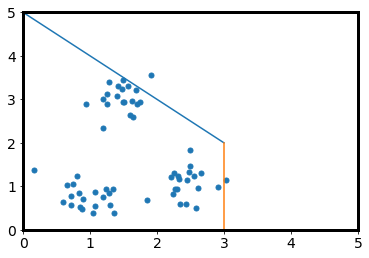

In [11]:
# Set three centers, the model should predict similar results
center_1 = np.array([1,1])
center_2 = np.array([2.5,1])
center_3 = np.array([1.5,3])

# Generate random data and center it to the three centers
data_1 = 0.3*np.random.randn(20, 2) + center_1
data_2 = 0.3*np.random.randn(20,2) + center_2
data_3 = 0.3*np.random.randn(20,2) + center_3

data = np.concatenate((data_1, data_2, data_3), axis = 0)
plt.scatter(data[:,0], data[:,1], s=25)
plt.xlim([0, 5])
plt.ylim([0, 5])
plt.plot([0,3], 
        [5, 2])
plt.plot([3,3], 
        [0, 2])

In [20]:
X_train, centers_new = Direct_Kmeans(data.T, data, 2, "no",  0.01,  20)

<Figure size 432x288 with 0 Axes>

In [24]:
data.T.shape
X_train.shape

(3, 60)

In [26]:
X_train.T

array([[0.65910975, 1.03514149, 0.        ],
       [1.3003745 , 0.56866745, 0.        ],
       [1.27928709, 0.84082204, 0.        ],
       [0.71278767, 0.78829576, 0.        ],
       [1.23987716, 0.93212777, 0.        ],
       [0.8103149 , 1.24167694, 0.        ],
       [0.59151192, 0.64201229, 0.        ],
       [1.06926525, 0.87555973, 0.        ],
       [0.84895303, 0.52379902, 0.        ],
       [1.20008628, 0.75412433, 0.        ],
       [1.34606652, 0.9301489 , 0.        ],
       [1.04419919, 0.38251901, 0.        ],
       [1.36172892, 0.39572983, 0.        ],
       [1.06785246, 0.54023324, 0.        ],
       [0.84224345, 0.85100369, 0.        ],
       [0.88251873, 0.48567705, 0.        ],
       [0.15937069, 1.37527065, 0.        ],
       [0.90216176, 0.71695129, 0.        ],
       [0.7148784 , 0.58035348, 0.        ],
       [0.7514845 , 1.05066839, 0.        ],
       [2.54984641, 1.24671088, 0.        ],
       [2.65876989, 1.31675263, 0.        ],
       [2.

# Function: Independent partition, Use centers as input to IO

In [ ]:
def Ind_partition_learn_Centers_to_IO(A,b,X, X_test, min_number_of_clusters, max_number_of_clusters, Testing):
    m = X.shape[0]
    k = X.shape[1]
    X_train = np.zeros ([m+1,k])
    X_train[0:m]= X
    XT = X.T
    for n in range(max_number_of_clusters):
        IO_points_dic[str(n+1)+'_cluster_centers'] = {}
        kmeans = KMeans(n_clusters=n + 1, random_state=0).fit(XT)
        kmeans.labels_
        X_train[m]= kmeans.labels_
        kmeans.cluster_centers_
        X_test_labeled = find_cluster(X_test, X_train)
        X_test_labeled[m] = kmeans.predict (X_test.T)

2
3
4
5


# Function: Independent Partition and Learning Model: Ind_partition_learn(A,b,X, max_number_of_clusters)
## partition then optimize

In [5]:
def Ind_partition_learn(A,b,X, X_test, max_number_of_clusters,figure):
    m = X.shape[0]
    k = X.shape[1]
    X_train = np.zeros ([m+1,k])
    X_train[0:m]= X
    XT = X.T        
    #max_number_of_clusters = 8
    dif =                   np.zeros (max_number_of_clusters)
    dif_train =             np.zeros (max_number_of_clusters)
    dif_test =              np.zeros (max_number_of_clusters)
    opt_gap =               np.zeros (max_number_of_clusters)
    dif_train_cluster_avg = np.zeros (max_number_of_clusters)
    IO_points_dic = {}
    for n in range(max_number_of_clusters):
        IO_points_dic[str(n+1)+'_cluster_centers'] = {}
        kmeans = KMeans(n_clusters=n + 1, random_state=0).fit(XT)
        kmeans.labels_
        X_train[m]= kmeans.labels_
        kmeans.cluster_centers_
        X_test_labeled = find_cluster(X_test, X_train)
        X_test_labeled[m] = kmeans.predict (X_test.T)
        unique_cluster = np.unique(X_train[m])
        IO_points = np.array ([])
        Cluster_avg = np.array ([])
        for i in unique_cluster:
            X1 = X_train.T[X_train.T[:,m] == i]
            X1 = X1[:,0:m].T
            Z1, C1 = IO(A,b,X1.T)
            IO_points = np.append (IO_points,Z1)
            IO_points_dic[str(n+1)+'_cluster_centers'][i] = Z1
            x_mean = np.zeros([m])
            dif_train[n] += sum (sum (abs (X1.T - Z1)))
            for j in range(m):
                x_mean[j] = X1.T[:,j].mean()
            Cluster_avg = np.append (Cluster_avg,x_mean)
            opt_gap[n]   += abs(abs(C1.dot(Z1)) - abs(C1.dot(X1))).sum()
            dif_train_cluster_avg[n] += sum (sum (abs (X1.T - x_mean)))
#out_of_sample testing error
            X_test_labeled1 = X_test_labeled.T[X_test_labeled.T[:,m] == i]
            X_test_labeled1 = X_test_labeled1[:,0:m].T
            if X_test_labeled1.shape[1] > 0 :
                dif_test[n] += sum (sum (abs (X_test_labeled1.T - Z1)))   
        if (X.shape[0] ==2) and figure:
            fig = plt.figure(figsize=(6,12))
            ax = fig.add_axes([0, 0, 1, 1])
            colors = ['r','g','b','c','m', 'y', 'k']
            s = 150
            for i in range (n+1):
                ci = colors[i]
                plt.scatter(IO_points[2*i+1], IO_points[2*i+2], marker=',', c=ci, s=300,
                       edgecolor="black", label="IO_point")
                plt.scatter(Cluster_avg[2*i+1], Cluster_avg[2*i+2],marker='x', c=ci, s=300,
                       edgecolor="black", label="Cluster_avg")
        #    plt.scatter(X[0, :], X[1, :], c="navy", s=s,
        #                edgecolor="black", label="data")
            count = 0
            for i in unique_cluster:
                ci = colors[count]
                X1 = X_train.T[X_train.T[:,2] == i]
                X1 = X1.T
                plt.scatter(X1[0, :], X1[1, :], c=ci,s=s,
                        edgecolor="black", label="data")
                count +=1
        #    plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=500, edgecolor="black")
            plt.xlim([0, 6])
            plt.ylim([0, 11])
            plt.plot([1,1], [1, 10], c="navy", linewidth=3)
            plt.plot([5,5], [1, 10], c="navy", linewidth=3)
            plt.plot([1,5], [10, 10], c="navy", linewidth=3)
            plt.plot([1,5], [1, 1], c="navy", linewidth=3)
            ax.fill_between([1,5], [10,10], [1,1], facecolor='black', alpha=0.05)
            ax.set_xlabel('x1')
            ax.set_ylabel('x2')
            plt.savefig('Saved_figures/UL2Dfig' + str(n) +'.png')
    return X_train, dif_train, opt_gap, dif_train_cluster_avg, dif_test,IO_points, Cluster_avg,x_mean
# X_train contains the original data and the final cluster labels
# dif_train is the sum of distances from the observations to the optimal inferred solutions
# opt_gap calculates the sum of optimality gaps of all the observations from their optimal obj values
# dif_train_cluster_avg contains the sum of the distances of the observations from their cluster averages 

# Function: Embedded Partition and Learning Model: Embedded_partition_learn(A,b,X, max_number_of_clusters)

In [23]:
def Embedded_partition_learn_2(A,b,X, X_test, max_number_of_clusters,figure):
    data = X.T
    #max_number_of_clusters = 8
    # Number of training data
    n = data.shape[0]
    # Number of features in the data
    c = data.shape[1]
    opt_gap_emb = np.zeros (max_number_of_clusters)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    dif = np.zeros (max_number_of_clusters)
    dif_train_base = np.zeros (max_number_of_clusters)
    dif_test =       np.zeros (max_number_of_clusters)
    for k in range(1,max_number_of_clusters+1):
        centers = np.random.randn(k,c)*std + mean
        centers_old = np.zeros(centers.shape) # to store old centers
        centers_new = deepcopy(centers) # Store new centers
        C1 = deepcopy(centers)
        clusters = np.zeros(n)
        distances = np.zeros((n,k))
        error = np.linalg.norm(centers_new - centers_old)
        IO_points = np.zeros ([1])
        Cluster_avg = np.zeros ([1])
        plt.figure()
        for i in range(k):
            data_temp = data[clusters == i]
    #         plt.scatter(data_temp[:,0], data_temp[:,1], s=7)
    #     #plt.scatter(data[:,0], data[:,1], s=7)
    #     plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)
    #     plt.xlim([0, 5])
    #     plt.ylim([0, 5])
    #     plt.plot([0,3], 
    #             [5, 2])
    #     plt.plot([3,3], 
    #             [0, 2])
        # When, after an update, the estimate of that center stays the same, exit loop
        #while error != 0:
        count = 0
        while error >= 0.01 and count < 20:
            count +=1 
            # Measure the distance to every center 
            for i in range(k):
                distances[:,i] = np.linalg.norm(data - centers_new[i], axis=1, ord = 1)
            # Assign all training data to closest center
            clusters = np.argmin(distances, axis = 1)
            centers_old = deepcopy(centers_new)
            # Calculate mean for every cluster and update the center
            for i in range(k):
                centers_new[i] , C1[i] = IO(A,b,data[clusters == i])
            error = np.linalg.norm(centers_new - centers_old)
        for i in range(n):
            dif_train_base[k-1] += np.min(distances[i,:])
        for i in range(k):
            data_temp = data[clusters == i]
            #opt_gap_emb[k-1]   += abs(abs(C1[i].dot(centers_new[i]))- abs(C1[i].dot(data_temp.T))).sum()
            opt_gap_emb[k-1]   += abs(C1[i].dot(centers_new[i])- C1[i].dot(data_temp.T)).sum()
        
        X_train = np.append (data.T,clusters)
        X_train = X_train.reshape(c+1,n)
        X_test_labeled = find_cluster(X_test, X_train)
        for i in np.unique(clusters):
            X_test_labeled1 = X_test_labeled.T[X_test_labeled.T[:,c] == i]
            X_test_labeled1 = X_test_labeled1[:,0:c].T
            if X_test_labeled1.shape[1] > 0 :
                dif_test[k-1] += sum (sum (abs (X_test_labeled1.T - centers_new[i,:])))   
#figure
        if (X.shape[0] ==2) and figure:
            plt.rcParams['font.size'] = 14
            plt.rcParams['axes.linewidth'] = 3
            # Create figure object and store it in a variable called 'fig'
            fig = plt.figure(figsize=(6, 12))
            ax = fig.add_axes([0, 0, 1, 1])
            colors = ['r','g','b','c','m', 'y', 'k']
            for i in range(k):
                ci = colors[i]
                data_temp = data[clusters == i]
                plt.scatter(data_temp[:,0], data_temp[:,1], c=ci, s=150, edgecolor="black")
            #plt.scatter(data[:,0], data[:,1], s=7)
                plt.scatter(centers_new[i,0], centers_new[i,1], marker=',', c=ci, s=500, edgecolor="black")
            plt.xlim([0, 6])
            plt.ylim([0, 11])
            plt.plot([1,1], [1, 10], c="navy", linewidth=3)
            plt.plot([5,5], [1, 10], c="navy", linewidth=3)
            plt.plot([1,5], [10, 10], c="navy", linewidth=3)
            plt.plot([1,5], [1, 1], c="navy", linewidth=3)
            ax.fill_between([1,5], [10,10], [1,1], facecolor='black', alpha=0.05)
            ax.set_xlabel('x1', labelpad=10)
            ax.set_ylabel('x2', labelpad=10)
            plt.savefig('Saved_figures/MLIO2Dfig' + str(k) +'.png')
            plt.show()
            
    return dif_train_base, centers_new, opt_gap_emb, data, dif_test, clusters

# find cluster function from points in clusters

In [24]:
def find_cluster_from_observations(X, X_train):
    m = X.shape[0]
    k = X.shape[1]
    X_test = np.zeros ([m+1,k])
    X_test[0:m]= X
    X_testT = X_test.T
    X_trainT = X_train.T
    temp = np.array([])
    iteration = 0
    for i in range(X_testT.shape[0]):
        for j in np.unique(X_train.T[:,m]):
            dist = 0
            count = 0
            for n in range(X_train.T.shape[0]):
                if X_trainT[n,m] == j:
                    #dist += np.linalg.norm(X_testT[i,0:m] - X_trainT[n,0:m]) 
                    dist += sum (abs (X_testT[i,0:m] - X_trainT[n,0:m]))
                    count += 1
            dist = dist / count
            if iteration == 0: 
                dist_min = dist
                iteration +=1
                X_test[m,i] = j
            elif dist < dist_min: 
                dist_min = dist
                X_test[m,i] = j
    return X_test

# find cluster function 2 (from centers)

In [20]:
def find_cluster_from_center(X, labels, centers):
    m = X.shape[0]
    k = X.shape[1]
    X_test = np.zeros ([m+1,k])
    X_test[0:m]= X
    X_testT = X_test.T
    for i in range (m):
        for label in range(labels.shape[0]):
            if label == 0:
                dist_min = sum (abs (X[i,:] - centers[label,:]))
                label_min = label
            else: 
                dist = sum (abs (X[i,:] - centers[label,:]))
                if dist <= dist_min: 
                    dist_min = dist
                    label_min = label
        X_test[i,m]= labels[label_min]
    return X_test

# draw 2D figure function

In [21]:
#add function

# bar graph result function

In [22]:
def find_cluster_from_center(*argv):
    plt.figure(figsize=(10, 7))
    s = 50
    for arg in argv:
        plt.bar (np.arange(1, arg.shape[0]+ 1), arg[:arg.shape[0]], width = 0.2)#, c="navy")
    plt.xlabel('Number of Clusters')
    plt.ylabel('Total Distances')
    plt.title('Comparison of the sum of Loss Functions with Different Models')
    plt.legend(loc = 0)